In [1]:
# prompt: CONNECT TO GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Shape: (96, 528)
Columns: Index(['Base_Beans (dry)', 'Base_Cassava', 'Base_Chili (red)', 'Base_Maize',
       'Base_Oranges (big size)', 'Base_Peas (fresh)', 'Base_Potatoes (Irish)',
       'Base_Sorghum', 'Base_Tomatoes', 'Birambo_Beans (dry)',
       ...
       'Rwagitima_Tomatoes', 'Rwamagana_Beans (dry)', 'Rwamagana_Cassava',
       'Rwamagana_Chili (red)', 'Rwamagana_Maize',
       'Rwamagana_Oranges (big size)', 'Rwamagana_Peas (fresh)',
       'Rwamagana_Potatoes (Irish)', 'Rwamagana_Sorghum',
       'Rwamagana_Tomatoes'],
      dtype='object', name='good', length=528)
Data Types: good
Base_Beans (dry)                float64
Base_Cassava                    float64
Base_Chili (red)                float64
Base_Maize                      float64
Base_Oranges (big size)         float64
                                 ...   
Rwamagana_Oranges (big size)    float64
Rwamagana_Peas (fresh)          float64
Rwamagana_Potatoes (Irish)      float64
Rwamagana_Sorghum               float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkka_nfh/945ggn18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgkka_nfh/btrg3nw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46164', 'data', 'file=/tmp/tmpgkka_nfh/945ggn18.json', 'init=/tmp/tmpgkka_nfh/btrg3nw2.json', 'output', 'file=/tmp/tmpgkka_nfh/prophet_modelejblqxdh/prophet_model-20241130180737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:07:37 - cmdstanpy - INFO - Ch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


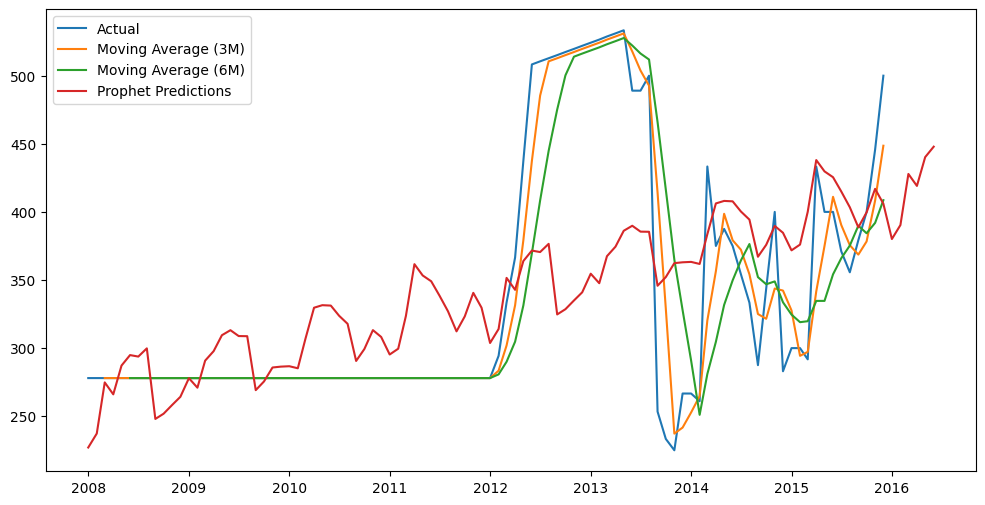

In [20]:
import pandas as pd
import os
import numpy as np # Import the numpy library

# Consolidate Date Columns
def consolidate_date(df):
    df['mp_year'] = df['mp_year'].astype(str)
    df['mp_month'] = df['mp_month'].astype(str).str.zfill(2)
    df['Date'] = pd.to_datetime(df['mp_year'] + '-' + df['mp_month'], format='%Y-%m')
    df.drop(['mp_year', 'mp_month'], axis=1, inplace=True)
    return df

# Add 'Good' Column by combining 'mkt_name' and 'cm_name'
def add_combined_column(df):
    df['good'] = df['mkt_name'] + '_' + df['cm_name']
    return df

# Process all files
file_paths = [
    "Tomatoes.csv", "Sorghum.csv", "Potatoes (Irish).csv", "Peas (fresh).csv",
    "Oranges (big size).csv", "Maize.csv", "Chili (red).csv", "Cassava.csv", "Beans (dry).csv"
]
dfs = []
for file in file_paths:
    # The following lines were not indented correctly, causing the IndentationError.
    # They should be indented to be part of the 'for' loop.
    df = pd.read_csv('/content/drive/MyDrive/FINAL EXAM/' + file) # Construct full file path using the loop variable 'file'
    df = consolidate_date(df)
    df = add_combined_column(df)
    dfs.append(df)


# Combine All DataFrames
combined_df = pd.concat(dfs)
combined_df = combined_df.pivot(index='Date', columns='good', values='mp_price')
combined_df.sort_index(inplace=True)
# Data Overview
print("Shape:", combined_df.shape)
print("Columns:", combined_df.columns)
print("Data Types:", combined_df.dtypes)

# Check Missing Dates
def check_date_continuity(df):
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
    missing_dates = date_range.difference(df.index)
    return missing_dates

missing_dates = check_date_continuity(combined_df)
if missing_dates.empty:
    print("No missing dates.")
else:
    print("Missing dates:", missing_dates)

# Missing Value Summary
missing_summary = combined_df.isnull().sum()
missing_percentage = (missing_summary / len(combined_df)) * 100
print("Missing Values (Count):", missing_summary)
print("Missing Values (%):", missing_percentage)

# Descriptive Statistics
print(combined_df.describe())
# Fill Missing Values Using Interpolation
filled_df = combined_df.interpolate(method='linear', limit_direction='both')

# Calculate the correlation matrix before using it
correlation_matrix = filled_df.corr()  # Assuming you want to use the filled data

mask = correlation_matrix.mask(np.eye(len(correlation_matrix), dtype=bool))
most_correlated = mask.stack().idxmax()
print("Most Correlated Pair:", most_correlated)

# Moving Average
filled_df['Moving_Avg_3M'] = filled_df['Base_Tomatoes'].rolling(window=3).mean()
filled_df['Moving_Avg_6M'] = filled_df['Base_Tomatoes'].rolling(window=6).mean()
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters Exponential Smoothing
model = ExponentialSmoothing(filled_df['Base_Tomatoes'], trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()
forecast = model_fit.forecast(steps=12)

from prophet import Prophet

# Prepare Data for Prophet
prophet_df = filled_df['Base_Tomatoes'].reset_index()  # Changed 'Tomatoes' to 'Base_Tomatoes'
prophet_df.columns = ['ds', 'y']

# Fit Model
model = Prophet()
model.fit(prophet_df)

# Predict Future Values
future = model.make_future_dataframe(periods=6, freq='MS')
forecast = model.predict(future)
forecast[['ds', 'yhat']].tail(6)

# Plot All Forecasts
import pandas as pd
import os
import numpy as np # Import the numpy library
import matplotlib.pyplot as plt # Import the plotting library
from google.colab import drive
drive.mount('/content/drive')

# ... (rest of your code) ...

# Plot All Forecasts
plt.figure(figsize=(12, 6))
# Change 'Tomatoes' to 'Base_Tomatoes' to match the actual column name in filled_df
plt.plot(filled_df['Base_Tomatoes'], label="Actual")
plt.plot(filled_df['Moving_Avg_3M'], label="Moving Average (3M)")
plt.plot(filled_df['Moving_Avg_6M'], label="Moving Average (6M)")
# You need to have calculated this column before plotting. Maybe you meant 'forecast'?
#plt.plot(filled_df['Holt_Predictions'], label="Holt Predictions")
plt.plot(forecast['ds'], forecast['yhat'], label="Prophet Predictions")
plt.legend()
plt.show()


